In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pathlib
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

2024-12-04 23:06:03.961468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733346363.990293   37418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733346363.998836   37418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 23:06:04.029440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_url = "https://www.muratkoklu.com/datasets/Rice_Image_Dataset.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

In [3]:
data_dir = pathlib.Path(archive + "/Rice_Image_Dataset").with_suffix('')
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

75000


In [4]:
batch_size = 32
img_height = 75
img_width = 75

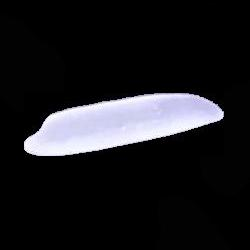

In [5]:
basmati = list(data_dir.glob('Basmati/*'))
PIL.Image.open(str(basmati[0]))

In [6]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.8,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.03,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.03,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 15000 files for training.


2024-12-04 23:06:33.022685: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 75000 files belonging to 5 classes.
Using 2250 files for validation.
Found 75000 files belonging to 5 classes.
Using 2250 files for validation.


2024-12-04 23:06:39.383190: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


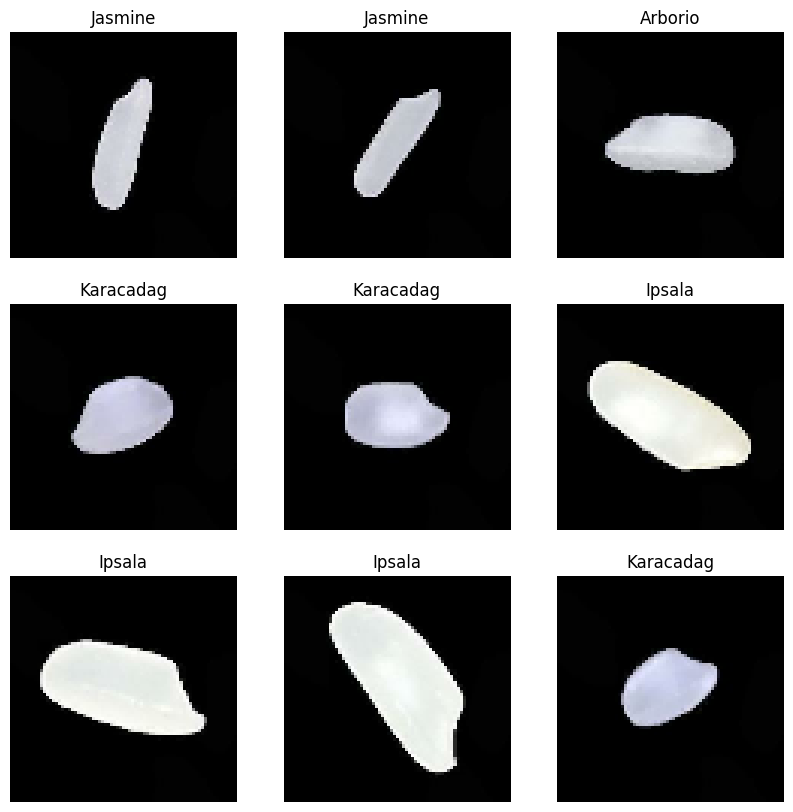

In [7]:
class_names = ds_train.class_names

num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 75, 75, 3)
(32,)


In [9]:
ds_train = ds_train.cache()
ds_val = ds_val.cache()

ds_train = ds_train.shuffle(buffer_size=1000)

## б) застосуйте перенесення навчання (transfer learning from pre-trained weights)

In [10]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False)

base_model.trainable = False

model = keras.Sequential([
	layers.Input(shape=(img_width, img_height, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation="sigmoid")
])

In [11]:
model.compile(
    optimizer='rmsprop',
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    batch_size = batch_size,
	epochs = 50,
    validation_data = ds_val
)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 431ms/step - accuracy: 0.4616 - loss: 144.7657 - val_accuracy: 0.6871 - val_loss: 2.9149
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6689 - loss: 3.9518 - val_accuracy: 0.8351 - val_loss: 1.1083
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 340ms/step - accuracy: 0.7418 - loss: 2.2603 - val_accuracy: 0.8507 - val_loss: 0.5814
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 342ms/step - accuracy: 0.8020 - loss: 1.0838 - val_accuracy: 0.8640 - val_loss: 0.6260
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 320ms/step - accuracy: 0.8382 - loss: 0.8627 - val_accuracy: 0.8493 - val_loss: 0.6580
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.8260 - loss: 0.7420 - val_accuracy: 0.7769 - val_loss: 1.3059
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 370ms/step - accuracy: 0.8459 - loss: 0.7936 - val_accuracy: 0.8738 - val_loss: 0.3544
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 477ms/step - accuracy: 0.8681 - loss: 0.5107 - val_ac

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

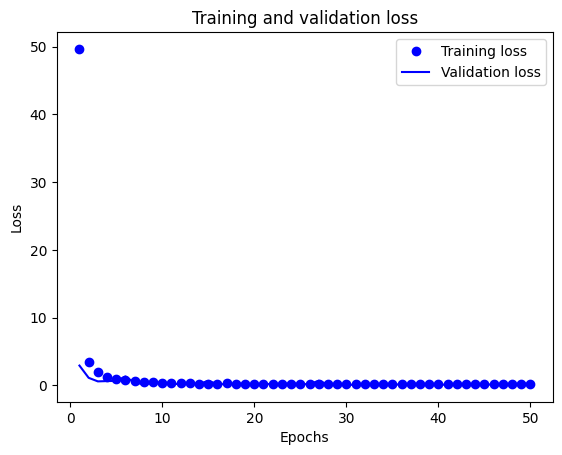

In [13]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
score = model.evaluate(ds_train, verbose=1) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9515 - loss: 0.1380
Test score: 0.156424880027771
Test accuracy: 0.9408888816833496


## Порівняйте результати

* Перенесене навчання виконується швидше.
* Навчена з нуля мережа показала кращі результати.

# 3. Рекурентні нейронні мережі
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:
а) навчить мережу і embedding шар з нуля (from scratch)
б) використовуючи pretrained word embeddings
 Результати порівняйте між собою і з одержаними раніш. 
Приклади:
https://github.com/natsakh/Data-Analysis/tree/main/Pr_7
https://keras.io/examples/nlp/text_classification_from_scratch/
https://keras.io/examples/nlp/bidirectional_lstm_imdb/
https://keras.io/examples/nlp/pretrained_word_embeddings/
* у деяких прикладах, з наведених вище, вирішується задача класифікації текстів за допомогою згорткових мереж, але вони можуть бути використані як приклад препроцесінга